In [1]:
import cv2
import numpy as np
import os

%load_ext autoreload
%autoreload 2

images/2-example.png
(200, 200)


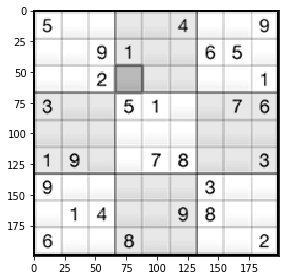

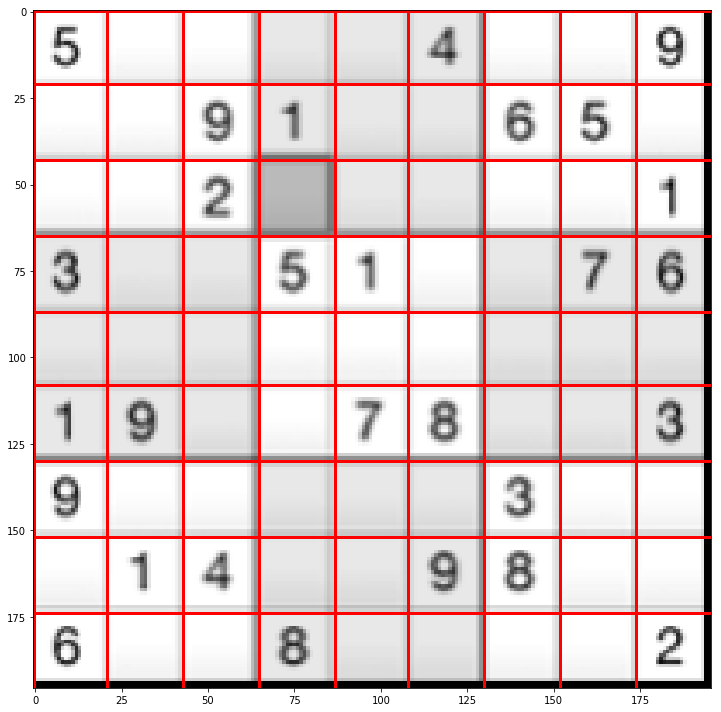

In [115]:
from sudoku.image_parser import (
    load_image, 
    enhance_grid_lines,
    find_corners_of_largest_polygon,
    crop_and_warp,
    enhance_digits,
    infer_grid
)

from sudoku.plotting import (
    show_image,
    draw_points,
    draw_rects
)


def is_image(file: str) -> bool: 
    return (
        file.endswith('.jpg') or 
        file.endswith('.jpeg') or 
        file.endswith('.png')
    )

directory = 'images/'


for file in os.listdir(directory):
    file = '2-example.png'
    if is_image(file):
        path = directory + file
        print(path)
        
        # Load image
        img = load_image(path)
        print(img.shape)
        
        show_image(img)

        # Step 1 - enhance lines
        enhanced_grid = enhance_grid_lines(img)
        
        # Step 2 - find corners
        corners = find_corners_of_largest_polygon(enhanced_grid)
#         show_image(draw_points(enhanced_grid, corners), figsize=(10, 10))    

        # Step 3 - apply crop and warp
        cropped = crop_and_warp(img, corners)
        
        # Apply twice
        # TODO Make pretty
        enhanced_grid = enhance_grid_lines(cropped)
        corners = find_corners_of_largest_polygon(enhanced_grid)
        cropped = crop_and_warp(cropped, corners)
        
#         show_image(cropped)
        
        # Step 4 - enhance digits
        enhanced_digits = enhance_digits(cropped)
        
#         show_image(enhanced_digits, figsize=(10, 10))
        
        # Step 5 - infer grid
        squares = infer_grid(cropped)
        show_image(draw_rects(cropped, squares), figsize=(10, 10))
        
        break

In [117]:
from sudoku.image_parser import (
    cut_from_rectangle
)

def extract_patches(img, squares):
    return [cut_from_rectangle(enhanced_digits, square) for square in squares]

patches = extract_patches(cropped, squares)

# for patch in patches:
#     show_image(patch)

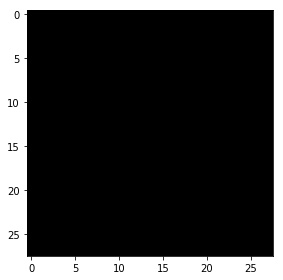

In [127]:
from sudoku.image_parser import find_largest_feature


def extract_digit(patch, size=28):
    
    h, w = patch.shape[:2]
    margin = int(np.mean([h, w]) / 2.5)
    _, bbox, seed = find_largest_feature(
        patch, [margin, margin], [w - margin, h - margin]
    )
    digit = cut_from_rectangle(patch, bbox)

    # Scale and pad the digit so that it fits a square of the digit size we're using for machine learning
    w = bbox[1][0] - bbox[0][0]
    h = bbox[1][1] - bbox[0][1]

    # Ignore any small bounding boxes
    if w > 0 and h > 0 and (w * h) > 100 and len(digit) > 0:
        return scale_and_centre(patch, size, 4)
    else:
        return np.zeros((size, size), np.uint8)

